# Building a DNN on MNIST Dataset

In [1]:
import tensorflow as tf
from tensorflow import keras 
import pandas as pd
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
import numpy as np 
import os 

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

In [3]:
X_train, y_train, X_valid, y_valid = X_train_full[:50000], y_train_full[:50000], X_train_full[50000:], y_train_full[50000:]

Function to rescale data between 0 and 1. Also reshapes input from (28, 28) to a single stream of 784 

In [4]:
norm = Normalizer(norm='max')
def app_norm(data):
    nsamples, x, y = data.shape
    data_2d = data.reshape((nsamples, x*y))
    return norm.fit_transform(data_2d)
X_train, X_valid, X_test = app_norm(X_train), app_norm(X_valid), app_norm(X_test)

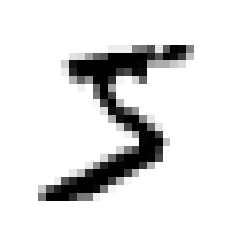

In [5]:
plt.imshow(X_train[0].reshape(28, 28), cmap='binary')
plt.axis('off')
plt.show()

In [6]:
y_train

array([5, 0, 4, ..., 8, 4, 8], dtype=uint8)

In [7]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs['loss'])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

In [8]:
keras.backend.clear_session
np.random.seed(42)
tf.random.set_seed(42)

In [9]:
model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=X_train.shape[1:]),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(
    loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=['accuracy']
)
# grow learning rate by 0.5% at each iteration 
expon_lr = ExponentialLearningRate(factor=1.005)

In [12]:
history = model.fit(
    X_train, y_train, epochs=1, validation_data = (X_valid, y_valid), callbacks=[expon_lr]
)

1563/1563 [==============================] - 5s 3ms/step - loss: nan - accuracy: 0.6282 - val_loss: nan - val_accuracy: 0.0991


Text(0, 0.5, 'loss')

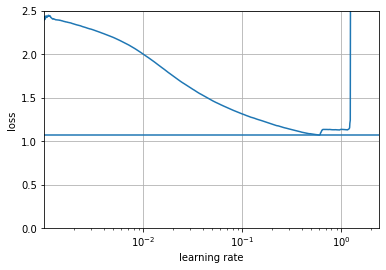

In [13]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, 2.5])
plt.grid()
plt.xlabel('learning rate')
plt.ylabel('loss')

In [14]:
# based on graph, use lr = 3e-1

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [15]:
model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=X_train.shape[1:]),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [16]:
model.compile(
    loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=3e-1), metrics=['accuracy']
)

In [17]:
run_index = 1 # increment at every run
run_logdir = os.path.join(os.curdir, 'mnist_logs', 'run_{:03d}'.format(run_index))
run_logdir

'.\\mnist_logs\\run_001'

In [18]:
class Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy')>0.98):
            print("98% accuracy reached in training, cancelling training.")
            self.model.stop_training = True

callback = Callback()
early_stopping_callback = keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = keras.callbacks.ModelCheckpoint('models/MNIST_model.h5', save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [19]:
history = model.fit(
    X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[early_stopping_callback, checkpoint_cb, tensorboard_cb]
)

Epoch 1/100
1563/1563 [==============================] - 5s 3ms/step - loss: 0.2452 - accuracy: 0.9235 - val_loss: 0.1462 - val_accuracy: 0.9574
Epoch 2/100
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1014 - accuracy: 0.9682 - val_loss: 0.1070 - val_accuracy: 0.9688
Epoch 3/100
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0674 - accuracy: 0.9783 - val_loss: 0.0968 - val_accuracy: 0.9727
Epoch 4/100
1563/1563 [==============================] - 4s 2ms/step - loss: 0.0500 - accuracy: 0.9838 - val_loss: 0.0903 - val_accuracy: 0.9760
Epoch 5/100
1563/1563 [==============================] - 4s 2ms/step - loss: 0.0375 - accuracy: 0.9881 - val_loss: 0.1020 - val_accuracy: 0.9752
Epoch 6/100
1563/1563 [==============================] - 4s 2ms/step - loss: 0.0281 - accuracy: 0.9906 - val_loss: 0.0922 - val_accuracy: 0.9771
Epoch 7/100
1563/1563 [==============================] - 4s 2ms/step - loss: 0.0211 - accuracy: 0.9929 - val_loss: 0.0805 - val_ac

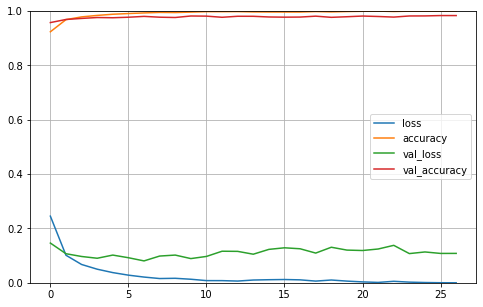

In [20]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [21]:
model = keras.models.load_model('models/MNIST_model.h5') # rollback to best model
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0751 - accuracy: 0.9808


[0.07510235160589218, 0.9807999730110168]

In [22]:
%tensorboard --logdir=.//mnist_logs --port=6006

UsageError: Line magic function `%tensorboard` not found.
